# Question 2
## 1. Introduction
In this task, we will be working with a subset of pitch-level data from an MLB season. On the basis of this data, the goal of this task is to develope a framework which is capable of predicting pitch types and the probability that a pitch is one of the pitch types. The pitch types include 4-Seam Fastball (FF), 2-Seam Fastball (FT), Curveball (CB), Slider (SL), and Changeup (CH).

In [519]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier 
from bayes_opt import BayesianOptimization 
from imblearn.over_sampling import SMOTE

## 2. Feature Preprocessing
First, we check the data type of each column and whether there are NaN values in each column. After that, we then encode our label, **pitch_type**, with value between 0 and 4. CB, CH, FF, FT, and SL are respectively represented by 0, 1, 2, 3, and 4. Finally, we convert the data types of all columns except **bat_score_before** and **field_score** to category types. The data types of **bat_score_before** and **field_score** remain as integer types.

In [452]:
# Load the training data
df = pd.read_csv('Q2_pitches_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480915 entries, 0 to 480914
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   inning            480915 non-null  int64 
 1   is_bottom         480915 non-null  int64 
 2   balls             480915 non-null  int64 
 3   strikes           480915 non-null  int64 
 4   outs_before       480915 non-null  int64 
 5   is_lhp            480915 non-null  int64 
 6   is_lhb            480915 non-null  int64 
 7   pitch_type        480915 non-null  object
 8   bat_score_before  480915 non-null  int64 
 9   field_score       480915 non-null  int64 
 10  basecode_before   480915 non-null  int64 
 11  batterid          480915 non-null  int64 
 12  pitcherid         480915 non-null  int64 
 13  cid               480915 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 51.4+ MB


In [453]:
# Encode the label and convert the data types
le = preprocessing.LabelEncoder()
le.fit(df['pitch_type'])
encoded_label = le.transform(df['pitch_type'])
df['pitch_type'] = pd.DataFrame(encoded_label)

categorical_variables = ['inning', 'is_bottom', 'balls', 'strikes', 'outs_before', 'is_lhp', 'is_lhb',
                         'pitch_type', 'basecode_before', 'batterid', 'pitcherid','cid']
for variable in categorical_variables:
    df[variable] = df[variable].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480915 entries, 0 to 480914
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   inning            480915 non-null  category
 1   is_bottom         480915 non-null  category
 2   balls             480915 non-null  category
 3   strikes           480915 non-null  category
 4   outs_before       480915 non-null  category
 5   is_lhp            480915 non-null  category
 6   is_lhb            480915 non-null  category
 7   pitch_type        480915 non-null  category
 8   bat_score_before  480915 non-null  int64   
 9   field_score       480915 non-null  int64   
 10  basecode_before   480915 non-null  category
 11  batterid          480915 non-null  category
 12  pitcherid         480915 non-null  category
 13  cid               480915 non-null  category
dtypes: category(12), int64(2)
memory usage: 13.9 MB


## 3. Methodology
### 3.1 Model Building and Hyperparameter Tuning
After preprocessing, we are going to define our machine learning problem. Again, our goal is to predict pitch types and the probability that a pitch is one of the pitch types. Therefore, on the basis of the given data, we are able to regard **pitch_type** as our classification label and further consider our problem as a classification problem. Besides, we regard **inning**, **is_bottom**, **balls**, **strikes**, **outs_before**, **is_lhp**, **is_lhb**, **bat_score_before**, **field_score**, **basecode_before**, **batterid**, **pitcherid**, and **cid** as our  predictors. In this section, we will define two important functions to assist us in building classification models and tuning their hyperparameters. 

In detail, we apply [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/), a gradient boosting framework that uses tree based learning algorithms, to our classification problem. It is designed to be distributed and efficient with the following advantages: faster training speed and higher efficiency, lower memory usage, better accuracy, capable of handling large-scale data, and support of parallel, distributed, and GPU learning. Next, regarding hyperparameter tuning, we use [**Bayesian Optimization**](https://github.com/fmfn/BayesianOptimization) instead of  Grid Search and Random Search since Bayesian Optimization is far more efficient in saving time and has better overall performance.

In [455]:
# Define a function to tune parameters using baysian optimization
def bayes_tuning(X, y, params, init_round=15, opt_round=25, random_state=42, n_estimators=10000, oversampling=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if oversampling == True:
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
    else:
        pass
           
    def lgb_function(learning_rate, num_leaves, max_depth, min_child_samples):

        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['num_leaves'] = int(round(num_leaves))
        params['max_depth'] = int(round(max_depth))
        params['min_child_samples'] = int(round(min_child_samples))
        
        lgbc = lgb.LGBMClassifier(**params)
        lgbc.fit(X_train, y_train)
        y_pred = lgbc.predict(X_test)
        accuracy = precision_score(y_pred, y_test, average='micro')

        return accuracy
      
    lgbBO = BayesianOptimization(lgb_function, {'learning_rate':(0.01,1.0), 'num_leaves':(30,200),                                            
                                                'max_depth':(1,30), 'min_child_samples':(20,80)}, random_state=42)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    model_auc = []
    for model in range(len(lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
        
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'], lgbBO.res[pd.Series(model_auc).idxmax()]['params']

In [456]:
# Define a function to fit the data using lightgbm with the optimal parameters
def lgb_classification(X, y, params, optimal_params, oversampling=False):
    
    for param in optimal_params[1].keys():
        if param == 'learning_rate':
            optimal_params[1][param] = round(optimal_params[1][param], 2)
        else:
            optimal_params[1][param] = int(round(optimal_params[1][param]))
    params.update(optimal_params[1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if oversampling == True:
        X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
        X_train = X_resampled
        y_train = y_resampled
    else:
        pass    
    lgbc = lgb.LGBMClassifier(**params)
    lgbc.fit(X_train, y_train)
    y_pred = lgbc.predict(X_test)
    accuracy = precision_score(y_pred, y_test, average='micro')
    cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    return lgbc, accuracy, cf_matrix 

### 3.2 Model Evaluation
After defining the functions for building LightGBM models and tuning hyperparameters, we then look at the distribution of our label, **pitch_type**. Unsurprisingly, the number of 4-Seam fastballs is way larger than the rest of the pitch types. As a result, in addition to directly fitting the original training dataset, we also try to set class weights for our label and balance the training dataset using over-sampling techniques, SMOTE. In the end of this section, we will evaluate the three approaches above through comparing overall test accuracy and confusion matrix.

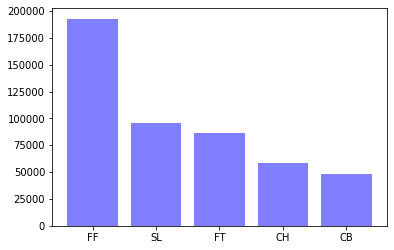

In [499]:
# Distribution of the label
types = ('FF', 'SL', 'FT', 'CH', 'CB')
y_pos = np.arange(len(types))
n = df['pitch_type'].value_counts().to_list()
plt.bar(y_pos, n, align='center', alpha=0.5, color='b')
plt.xticks(y_pos, types)
plt.show()

In [457]:
# Model l (original dataset)
X = df.drop('pitch_type', axis=1).to_numpy()
y = df[['pitch_type']].to_numpy().ravel()
params = {'boosting_type':'gbdt', 'objective':'multiclass', 'num_class':5, 'class_weight':None}
optimal_params_1 = bayes_tuning(X, y, params)
lgbc_results_1 = lgb_classification(X, y, params, optimal_params_1)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.5202   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.4983   |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.5025   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.5112   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.521    |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.5102   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.5173   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.447    |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.5116   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.4841   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.5213   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.5223   |  0.2662   | 

In [466]:
# Model 2 (over-sampling technique)
params = {'boosting_type':'gbdt', 'objective':'multiclass', 'num_class':5, 'class_weight':None}
optimal_params_2 = bayes_tuning(X, y, params, oversampling=True)
lgbc_results_2 = lgb_classification(X, y, params, optimal_params_2, oversampling=True)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.4725   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.4343   |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.4668   |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.4631   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.4662   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.4506   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.4693   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.3749   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.4529   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.418    |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.4668   |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.4709   |  0.2662   | 

In [470]:
# Model 3 (class weight adjustment)
params = {'boosting_type':'gbdt', 'objective':'multiclass', 'num_class':5, 'class_weight':'balanced'}
optimal_params_3 = bayes_tuning(X, y, params)
lgbc_results_3 = lgb_classification(X, y, params, optimal_params_3)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.4651   |  0.3808   |  28.57    |  63.92    |  131.8    |
|  2        |  0.4248   |  0.1645   |  5.524    |  23.49    |  177.2    |
|  3        |  0.463    |  0.6051   |  21.53    |  21.24    |  194.9    |
|  4        |  0.4562   |  0.8341   |  7.158    |  30.91    |  61.18    |
|  5        |  0.4592   |  0.3112   |  16.22    |  45.92    |  79.51    |
|  6        |  0.4437   |  0.6157   |  5.045    |  37.53    |  92.28    |
|  7        |  0.4656   |  0.4615   |  23.77    |  31.98    |  117.4    |
|  8        |  0.3592   |  0.5965   |  2.347    |  56.45    |  58.99    |
|  9        |  0.4466   |  0.0744   |  28.52    |  77.94    |  167.4    |
|  10       |  0.4054   |  0.3116   |  3.832    |  61.05    |  104.8    |
|  11       |  0.462    |  0.1308   |  15.36    |  22.06    |  184.6    |
|  12       |  0.4609   |  0.2662   | 

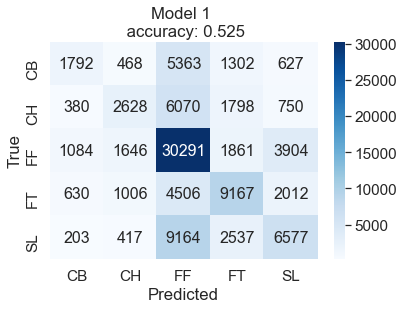

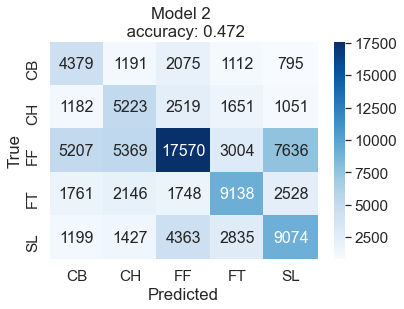

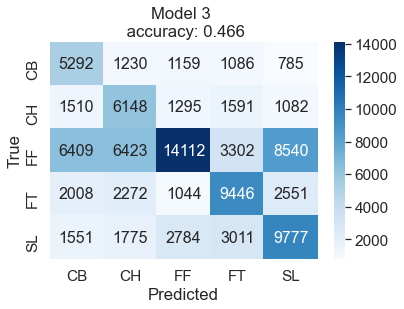

In [531]:
# Compare test accuracy and confusion matrix
for result in [lgbc_results_1, lgbc_results_2, lgbc_results_3]:
    model_index = [lgbc_results_1, lgbc_results_2, lgbc_results_3].index(result)+1
    label = ['CB', 'CH', 'FF', 'FT', 'SL']
    data = result[2]
    df_cm = pd.DataFrame(data, columns=np.unique(label), index=np.unique(label))
    df_cm.index.name = 'True'
    df_cm.columns.name = 'Predicted'        
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g')
    plt.title('Model {} \n accuracy: {}'.format(model_index ,round(result[1],3)))
    plt.show()

**Model 1** represents that we train a LightGBM model and tune its hyperparameters using the original training dataset. **Model 2** represents that we train a LightGBM model and tune its hyperparameters using the resampled training dataset. **Model 3** represents that we train a LightGBM model with class weights and tune its hyperparameters using the original training dataset. It's worthy to note that the test dataset is the same for each model.

As shown in above figures, **Model l** outperforms **Model 2** and **Model 3** on overall test accuracy. However, if we focus on their confusion matrices, we can find out that **Model l** is extremely good at predicting 4-Seam Fastball while **Model 2** and **Model 3** are good at predicting the rest of the pitch types (2-Seam Fastball, Curveball, Slider, and Changeup). The reason is that we use over-sampling technique to resample the training dataset in **Model 2** and set class weights for the label in **Model 3** in order to deal with potential imbalance issue.

Moreover, we then try to figure out which features have significant impact on predicting **pitch_type** by calculating feature importance reagrding each proposed model. As shown in below figures, it's obvious that **pitcherid**, **cid**, and **batterid** have the significant impacts on predicting **pitch_type**. This is pretty reasonable since every pitch is a battle between batter and batterymate. 

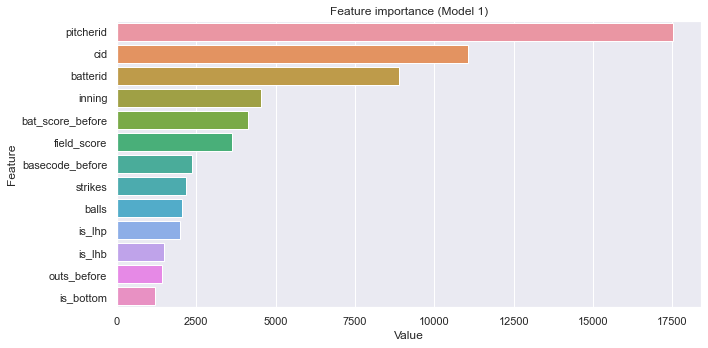

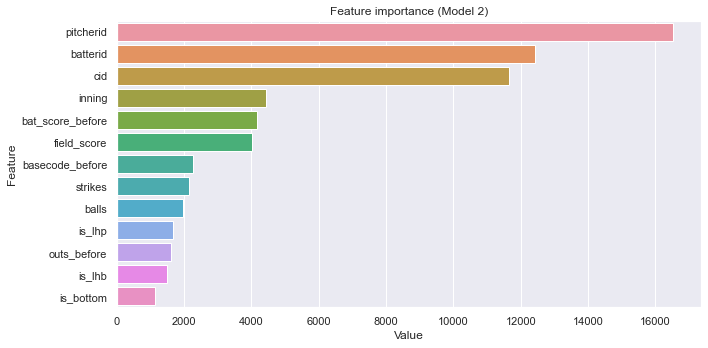

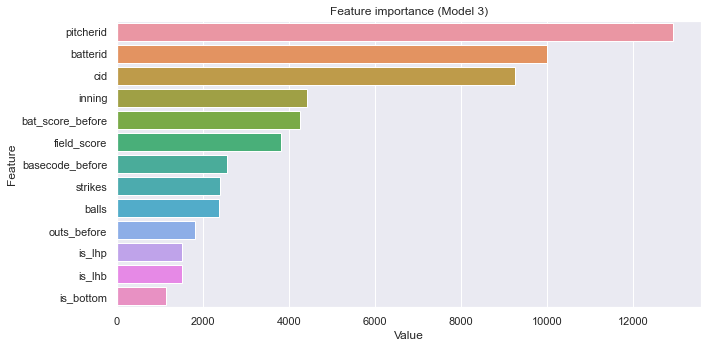

In [656]:
for result in [lgbc_results_1, lgbc_results_2, lgbc_results_3]:
    model_index = [lgbc_results_1, lgbc_results_2, lgbc_results_3].index(result)+1
    feature_imp = pd.DataFrame({'Value':result[0].feature_importances_,
                                'Feature':df.drop('pitch_type', axis=1).columns})
    plt.figure(figsize=(10, 5))
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:13])
    plt.title('Feature importance (Model {})'.format(model_index))
    plt.tight_layout()
    plt.show()

### 3.3 Voting Classifier
As mentioned in the previous section, **Model 1**, **Model 2**, and **Model 3** have their own advantages and disadvantages. Therefore, we are going to use **voting**, an ensemble machine learning algorithm, to combine the predictions from our three proposed models. It is a technique that may be used to improve model performance, ideally achieving better performance than any single model used in the ensemble.

In the case of classification, the predictions for each label are summed and the label with the majority vote is predicted. There are two approaches to the majority vote prediction for classification: **hard voting** and **soft voting**. **hard voting** uses predicted class labels for majority rule voting while **soft voting** predicts the class label based on the argmax of the sums of the predicted probabilities.

As shown in below figure, comparing with the result of **Model 1**, **Model after voting** maintains similar overall test accuracy while improves the performance on predicting 2-Seam Fastball, Curveball, Slider, and Changeup. In brief, **voting classifier** basically combines advantages of our three proposed methods.

In [606]:
# Build a voting classifer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eclf = VotingClassifier(estimators=[('model_1', lgbc_results_1[0]),
                                    ('model_2', lgbc_results_2[0]),
                                    ('model_3', lgbc_results_3[0])], voting='soft')
eclf = eclf.fit(X_train, y_train)

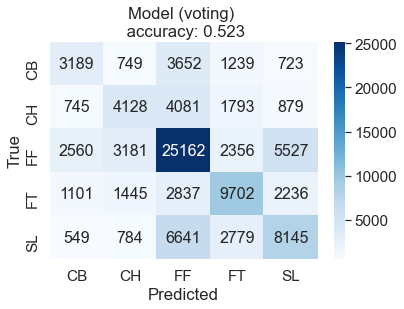

In [607]:
# Test accuracy and confusion matrix
y_pred = eclf.predict(X_test)
accuracy = precision_score(y_pred, y_test, average="micro")

label = ['CB', 'CH', 'FF', 'FT', 'SL']
data = confusion_matrix(y_true=y_test, y_pred=y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(label), index=np.unique(label))
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'        
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g')
plt.title('Model (voting) \n accuracy: {}'.format(round(accuracy,3)))
plt.show()

## 4. Prediction
After finishing preparing our model, we then use our model to provide probabilities for each pitch type in the file named **"Q2_pitches_test.csv"**. Please to the updated csv file in the folder named **"Q2"**.

In [635]:
# Load the test data
df_test = pd.read_csv('Q2_pitches_test.csv')

In [636]:
# Predict probabilities
X = df_test.drop(['FF', 'FT', 'CB', 'SL', 'CH'], axis=1).to_numpy()
y_pred_prob = eclf. predict_proba(X)

In [637]:
# Update the csv file
df_test['FF'] = y_pred_prob[:,2]
df_test['FT'] = y_pred_prob[:,3]
df_test['CB'] = y_pred_prob[:,0]
df_test['SL'] = y_pred_prob[:,4]
df_test['CH'] = y_pred_prob[:,1]
df_test.to_csv('Q2_pitches_test.csv', index=False)

## 5. Conclusion
In this task, in order to predicting pitch types and the probability that a pitch is one of the pitch types, we basically develop a framework including preprocessing features, building predictive models, tuning hyperparameters, evaluating the models, and calculating feature importance. Although the result might not be perfect, I believe that I still provide a reliable framework to deal with this kind of issue.

## 6. What other information would you have wanted to improve your predictions’ performance?
Apparently, pitch type prediction is a complex challenge since batterymates put a lot of effort into making it difficult. As mentioned in Section 3.2, we figure out that **pitcherid**, **cid**, and **batterid** have the significant impacts on predicting **pitch_type**. This founding is pretty reasonable since every pitch is a battle between batter and batterymate. In this task, the given data basically contains the information about the situation on the field. Therefore, I believe that we are able to improve our predictions’ performance if we could get more information about pitchers, catchers, and batters.

First, regarding batterymates, it will be really helpful if we know previous pitch number, previous pitch type, previous pitch location, previous pitch stats, previous pitch result, and previous batting result. Moreover, for example, we could calculate the probability of 4-seam fastball during previous 5 pitches or 10 pitches. Similarly, we could apply this concept on slider, curveball, changeup, and so. Besides, we could calculate the strikes ratio during previous 5 pitches or 10 pitches. Regarding batters, it will be really helpful if we know previous swinging-or-not, and previous batting result. Furthermore, we could calculate the swinging probability during previous 5 pitches or 10 pitches. Then, we could also split the swinging probability into multiple swinging probabilities regarding different pitch types.